# E4-NAVER REVIEW 네이버 리뷰

## 네이버 영화 댓글 데이터셋 준비

(참고 : https://github.com/e9t/nsmc)

* Naver sentiment movie corpus v1.0 데이터셋은 총 20만 개 영화 리뷰 텍스트로 구성

* 긍정라벨 = 1, 부정라벨 = 0

* 20만 개의 데이터 중, 15만 개는 훈련용데이터, 5만 개는 테스트데이터

* (터미널 열고) 아래의 명령어로 데이터셋 다운로드 및 디렉토리로 파일 이동  
wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt  
wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt  
mv ratings_*.txt ~/aiffel/sentiment_classification

### (1) 데이터 준비

* 필요한 모듈과 데이터 불러오기

In [1]:
import pandas as pd
from pandas import DataFrame
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 훈련 데이터 읽어보기 : 상위 5개 리뷰 출력??
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
# 테스트 데이터도 읽어보기
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


* 훈련데이터/ 테스트데이터 개수 확인

In [3]:
print("훈련 데이터 개수: {}, 테스트 데이터 개수: {}".format(len(train_data), len(test_data)))

훈련 데이터 개수: 150000, 테스트 데이터 개수: 50000


* 참고 : imdb 예제의 방법을 적용하여 다운받은 데이터 읽어오기

In [4]:
print(train_data[0:5])  # 1번째 리뷰데이터로부터 5개까지만 출력??

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [5]:
print(test_data[3:4])  # 4번째 리뷰데이터로부터 1개까지만 출력 = 즉, 4번째리뷰만...

        id                          document  label
3  6825595  지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0


### (2) 데이터 로더 구성

* 목표 : imdb.data_loader()와 동일하게 작동하는 나만의 data_loader() 만들기

#### a) 정규 표현식을 통한 데이터 정제

In [6]:
# 훈련데이터의 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/home/aiffel-dj42/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [7]:
# 테스트데이터의 한글과 공백을 제외하고 모두 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data[:5]

/home/aiffel-dj42/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


#### b) '데이터 중복 제거'부터 'X_train, y_train, X_test, y_test, word_to_index 리턴'까지

* 데이터의 중복 제거  
* NaN 결측치 제거  
* 한국어 토크나이저로 토큰화  
* 불용어(Stopwords) 제거  
* 사전word_to_index 구성  
* 텍스트 스트링을 사전 인덱스 스트링으로 변환  
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [8]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 정의

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    train_data = train_data.dropna(how = 'any') # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any') # 결측치 제거

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### (3) 모델구성을 위한 데이터 분석 및 가공

#### a) 데이터셋 내 문장 길이 분포 확인 및 문장 최대 길이 지정

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.921936491410724
문장길이 최대 :  83
문장길이 표준편차 :  11.455371467060123
pad_sequences maxlen :  36
전체 문장의 0.9328891202498698%가 maxlen 설정값 이내에 포함됩니다. 


#### b) keras.preprocessing.sequence.pad_sequences()을 이용한 패딩 추가

In [12]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(143682, 36)


### (4) 모델구성 및 validation set 구성

* 모델 훈련 전, 훈련용 데이터셋 중 60000건을 분리하여 검증셋으로 설정 : 적당한 수량은 얼마일까? 생각해보기

In [13]:
# 훈련데이터의 40% 분량으로 validation set 분리
x_val = X_train[:57472]   
y_val = y_train[:57472]

# validation set을 제외한 나머지
partial_x_train = X_train[57472:]
partial_y_train = y_train[57472:]

print(partial_x_train.shape)

(86210, 36)


#### a) RNN 모델

In [14]:
# 모델 설계
vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 자주 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 하였으나 변경가능
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10 # 20번, 15번, 10번, 5번 시도.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500, # 배치 사이즈 512 -> 60 -> 100 -> 700 으로 변경
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 2s 9ms/step - loss: 0.6129 - accuracy: 0.6393 - val_loss: 0.4267 - val_accuracy: 0.8205
Epoch 2/10
173/173 [==============================] - 1s 7ms/step - loss: 0.3768 - accuracy: 0.8412 - val_loss: 0.3733 - val_accuracy: 0.8340
Epoch 3/10
173/173 [==============================] - 1s 7ms/step - loss: 0.3335 - accuracy: 0.8603 - val_loss: 0.3698 - val_accuracy: 0.8396
Epoch 4/10
173/173 [==============================] - 1s 7ms/step - loss: 0.3171 - accuracy: 0.8671 - val_loss: 0.3793 - val_accuracy: 0.8338
Epoch 5/10
173/173 [==============================] - 1s 7ms/step - loss: 0.3069 - accuracy: 0.8715 - val_loss: 0.3762 - val_accuracy: 0.8382
Epoch 6/10
173/173 [==============================] - 1s 7ms/step - loss: 0.2977 - accuracy: 0.8757 - val_loss: 0.3764 - val_accuracy: 0.8363
Epoch 7/10
173/173 [==============================] - 1s 7ms/step - loss: 0.2915 - accuracy: 0.8778 - val_loss: 0.3844 - val_accuracy: 0.8340
Epoch 

In [16]:
# 평가
results = model.evaluate(X_test, y_test, verbose=1)

print(results)

1514/1514 [==============================] - 3s 2ms/step - loss: 0.4172 - accuracy: 0.8263
[0.41719332337379456, 0.8263249397277832]


* 임베드 모델 (구글의 Word2Vec)

In [17]:
import os
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['computer']
vector     # 300dim의 워드 벡터

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

* 임베딩 매트릭스

In [18]:
vocab_size = 10000    # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [19]:
# 임베드 모델 구성
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.LSTM(8))   # 자주 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 하였으나 변경가능
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

Embed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 임베드 모델 훈련
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 40ms/step - loss: 0.6702 - accuracy: 0.5585 - val_loss: 0.5152 - val_accuracy: 0.7812
Epoch 2/10
173/173 [==============================] - 7s 38ms/step - loss: 0.4266 - accuracy: 0.8179 - val_loss: 0.3996 - val_accuracy: 0.8265
Epoch 3/10
173/173 [==============================] - 7s 38ms/step - loss: 0.3519 - accuracy: 0.8541 - val_loss: 0.3815 - val_accuracy: 0.8315
Epoch 4/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3258 - accuracy: 0.8666 - val_loss: 0.3657 - val_accuracy: 0.8428
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3015 - accuracy: 0.8798 - val_loss: 0.3698 - val_accuracy: 0.8401
Epoch 6/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2860 - accuracy: 0.8864 - val_loss: 0.3706 - val_accuracy: 0.8424
Epoch 7/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2710 - accuracy: 0.8935 - val_loss: 0.3832 - val_accuracy: 0.8411

In [21]:
# 임베드 모델 평가
results = Embed_model.evaluate(X_test, y_test, verbose=1)
print(results)

1514/1514 [==============================] - 3s 2ms/step - loss: 0.4067 - accuracy: 0.8326
[0.4067246615886688, 0.832582950592041]


In [22]:
# RNN 모델 히스토리
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


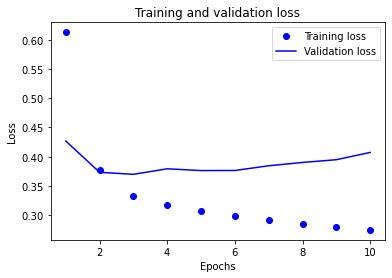

In [23]:
# RNN 모델 loss, accuracy 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

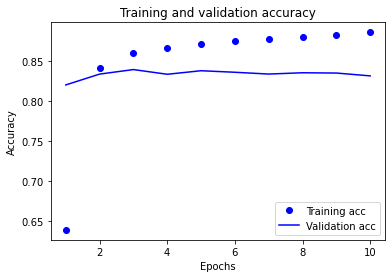

In [24]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
# 학습된 임베딩 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
embedding_layer = Embed_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [27]:
# 학습 파라미터 저장
import os
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word_vector_dim = 300
Embed_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Embed_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
# 임베딩 파라미터 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_word2vec_file_path, binary=False)
word_vectors.similar_by_word("집")

[('사촌', 0.8074449896812439),
 ('띄', 0.8048067092895508),
 ('랄', 0.8034842014312744),
 ('역시', 0.8029295802116394),
 ('재생', 0.8027658462524414),
 ('소서', 0.8008773922920227),
 ('주체', 0.7999964952468872),
 ('민', 0.7992440462112427),
 ('이순재', 0.7988442182540894),
 ('반영', 0.7982040643692017)]

In [30]:
# 성능 개선
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [31]:
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [32]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))   # 자주 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 하였으나 변경가능
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 40ms/step - loss: 0.6720 - accuracy: 0.5633 - val_loss: 0.5639 - val_accuracy: 0.7787
Epoch 2/10
173/173 [==============================] - 6s 35ms/step - loss: 0.4551 - accuracy: 0.8137 - val_loss: 0.3935 - val_accuracy: 0.8290
Epoch 3/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3568 - accuracy: 0.8513 - val_loss: 0.3741 - val_accuracy: 0.8339
Epoch 4/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3276 - accuracy: 0.8669 - val_loss: 0.3823 - val_accuracy: 0.8346
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3107 - accuracy: 0.8746 - val_loss: 0.3818 - val_accuracy: 0.8376
Epoch 6/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2967 - accuracy: 0.8816 - val_loss: 0.3732 - val_accuracy: 0.8372
Epoch 7/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2833 - accuracy: 0.8883 - val_loss: 0.3860 - val_accuracy: 0.8378

In [35]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1514/1514 [==============================] - 3s 2ms/step - loss: 0.4200 - accuracy: 0.8297
[0.4199727773666382, 0.8296501040458679]


#### b) 1-D CNN 모델

In [36]:
# 모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# 두 번째 성분값이 7이었을 때 오류가 떠서 같은 조원 '안석현'님의 도움을 받아 6으로 수정 후 해결!! 왜 실해되는지 이유는 모르겠음
model.add(keras.layers.Conv1D(16, 6, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
# 아래 것도 두 번째 성분값이 7이었을 때 오류가 떠서 같은 조원 '안석현'님의 도움을 받아 6으로 수정 후 해결!!
model.add(keras.layers.Conv1D(16, 6, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [37]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/10
173/173 [==============================] - 27s 154ms/step - loss: 0.5515 - accuracy: 0.7071 - val_loss: 0.3839 - val_accuracy: 0.8302
Epoch 2/10
173/173 [==============================] - 1s 5ms/step - loss: 0.3526 - accuracy: 0.8477 - val_loss: 0.3632 - val_accuracy: 0.8408
Epoch 3/10
173/173 [==============================] - 1s 5ms/step - loss: 0.3150 - accuracy: 0.8684 - val_loss: 0.3626 - val_accuracy: 0.8417
Epoch 4/10
173/173 [==============================] - 1s 5ms/step - loss: 0.2880 - accuracy: 0.8827 - val_loss: 0.3693 - val_accuracy: 0.8398
Epoch 5/10
173/173 [==============================] - 1s 5ms/step - loss: 0.2618 - accuracy: 0.8953 - val_loss: 0.3816 - val_accuracy: 0.8381
Epoch 6/10
173/173 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.9114 - val_loss: 0.4044 - val_accuracy: 0.8358
Epoch 7/10
173/173 [==============================] - 1s 5ms/step - loss: 0.1994 - accuracy: 0.9263 - val_loss: 0.4299 - val_accuracy: 0.8304
Epo

In [38]:
print(len(partial_x_train[2]))

36


In [39]:
# 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1514/1514 [==============================] - 9s 6ms/step - loss: 0.5518 - accuracy: 0.8199
[0.551813542842865, 0.819901704788208]


In [40]:
# 임베드 모델 구성
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.LSTM(8))
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

Embed_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 임베드 모델 훈련
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 40ms/step - loss: 0.6926 - accuracy: 0.5039 - val_loss: 0.6912 - val_accuracy: 0.5272
Epoch 2/10
173/173 [==============================] - 6s 36ms/step - loss: 0.5702 - accuracy: 0.6801 - val_loss: 0.4072 - val_accuracy: 0.8232
Epoch 3/10
173/173 [==============================] - 6s 35ms/step - loss: 0.3679 - accuracy: 0.8426 - val_loss: 0.3787 - val_accuracy: 0.8335
Epoch 4/10
173/173 [==============================] - 6s 36ms/step - loss: 0.3299 - accuracy: 0.8633 - val_loss: 0.3668 - val_accuracy: 0.8407
Epoch 5/10
173/173 [==============================] - 6s 35ms/step - loss: 0.3083 - accuracy: 0.8743 - val_loss: 0.3836 - val_accuracy: 0.8341
Epoch 6/10
173/173 [==============================] - 6s 36ms/step - loss: 0.2902 - accuracy: 0.8831 - val_loss: 0.3724 - val_accuracy: 0.8400
Epoch 7/10
173/173 [==============================] - 6s 35ms/step - loss: 0.2762 - accuracy: 0.8905 - val_loss: 0.3817 - val_accuracy: 0.8359

In [42]:
# 임베드 모델 평가
results = Embed_model.evaluate(X_test,  y_test, verbose=1)
print(results)

1514/1514 [==============================] - 3s 2ms/step - loss: 0.3990 - accuracy: 0.8322
[0.39899665117263794, 0.8321698307991028]


In [43]:
# CNN 모델 히스토리
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


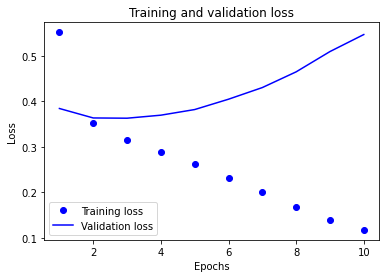

In [44]:
# CNN 모델 loss, accuracy 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

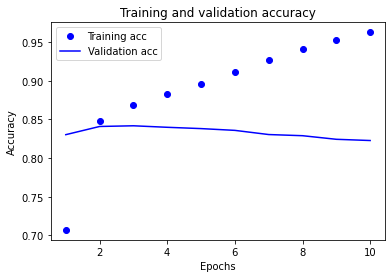

In [45]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
# 학습된 임베딩 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [47]:
embedding_layer = Embed_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [48]:
# 학습 파라미터 저장
import os
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word_vector_dim = 300
Embed_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Embed_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
# 임베딩 파라미터 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_word2vec_file_path, binary=False)
word_vectors.similar_by_word("집")

[('처럼', 0.7981947660446167),
 ('카지노', 0.7953349947929382),
 ('깨', 0.7949219942092896),
 ('미쳤', 0.7929275631904602),
 ('손잡', 0.7920088768005371),
 ('들어갈', 0.7909311056137085),
 ('아주', 0.7909188270568848),
 ('원한다면', 0.7906951308250427),
 ('지요', 0.7901337742805481),
 ('무서움', 0.7896856069564819)]

In [51]:
# 성능 개선
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [52]:
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [53]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [55]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 40ms/step - loss: 0.6609 - accuracy: 0.5660 - val_loss: 0.4908 - val_accuracy: 0.7887
Epoch 2/10
173/173 [==============================] - 6s 37ms/step - loss: 0.4209 - accuracy: 0.8224 - val_loss: 0.3837 - val_accuracy: 0.8348
Epoch 3/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3511 - accuracy: 0.8535 - val_loss: 0.3720 - val_accuracy: 0.8366
Epoch 4/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3259 - accuracy: 0.8652 - val_loss: 0.3724 - val_accuracy: 0.8356
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3113 - accuracy: 0.8736 - val_loss: 0.3759 - val_accuracy: 0.8366
Epoch 6/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2992 - accuracy: 0.8792 - val_loss: 0.3728 - val_accuracy: 0.8396
Epoch 7/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2862 - accuracy: 0.8858 - val_loss: 0.3791 - val_accuracy: 0.8394

In [56]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1514/1514 [==============================] - 4s 2ms/step - loss: 0.3996 - accuracy: 0.8323
[0.39957287907600403, 0.8322524428367615]


#### c) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [57]:
# GMP모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [58]:
# GMP모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6973 - val_loss: 0.5133 - val_accuracy: 0.8054
Epoch 2/10
173/173 [==============================] - 1s 4ms/step - loss: 0.4267 - accuracy: 0.8235 - val_loss: 0.3905 - val_accuracy: 0.8267
Epoch 3/10
173/173 [==============================] - 1s 4ms/step - loss: 0.3539 - accuracy: 0.8495 - val_loss: 0.3735 - val_accuracy: 0.8335
Epoch 4/10
173/173 [==============================] - 1s 4ms/step - loss: 0.3209 - accuracy: 0.8655 - val_loss: 0.3712 - val_accuracy: 0.8350
Epoch 5/10
173/173 [==============================] - 1s 4ms/step - loss: 0.2973 - accuracy: 0.8775 - val_loss: 0.3739 - val_accuracy: 0.8354
Epoch 6/10
173/173 [==============================] - 1s 5ms/step - loss: 0.2780 - accuracy: 0.8861 - val_loss: 0.3800 - val_accuracy: 0.8339
Epoch 7/10
173/173 [==============================] - 1s 6ms/step - loss: 0.2616 - accuracy: 0.8945 - val_loss: 0.3882 - val_accuracy: 0.8328
Epoch 

In [59]:
# 평가
results = model.evaluate(X_test, y_test, verbose=1)

print(results)

1514/1514 [==============================] - 2s 1ms/step - loss: 0.4263 - accuracy: 0.8265
[0.42626139521598816, 0.8264694809913635]


In [60]:
# 임베드 모델 구성
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.LSTM(8))
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

Embed_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 임베드 모델 훈련
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 39ms/step - loss: 0.6909 - accuracy: 0.5093 - val_loss: 0.6277 - val_accuracy: 0.7208
Epoch 2/10
173/173 [==============================] - 6s 37ms/step - loss: 0.4404 - accuracy: 0.8054 - val_loss: 0.3770 - val_accuracy: 0.8351
Epoch 3/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3482 - accuracy: 0.8526 - val_loss: 0.3670 - val_accuracy: 0.8382
Epoch 4/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3222 - accuracy: 0.8665 - val_loss: 0.3687 - val_accuracy: 0.8391
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3014 - accuracy: 0.8762 - val_loss: 0.3648 - val_accuracy: 0.8407
Epoch 6/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2851 - accuracy: 0.8849 - val_loss: 0.3708 - val_accuracy: 0.8412
Epoch 7/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2703 - accuracy: 0.8910 - val_loss: 0.3727 - val_accuracy: 0.8412

In [62]:
# 임베드 모델 평가
results = Embed_model.evaluate(X_test, y_test, verbose=1)
print(results)

1514/1514 [==============================] - 3s 2ms/step - loss: 0.4115 - accuracy: 0.8310
[0.4114568829536438, 0.8309719562530518]


In [63]:
# GMP 모델 히스토리
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


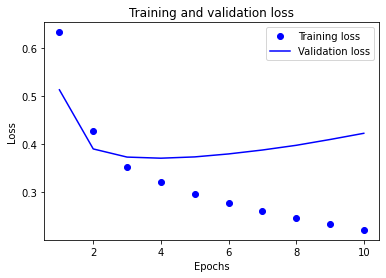

In [64]:
# GMP 모델 loss, accuracy 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

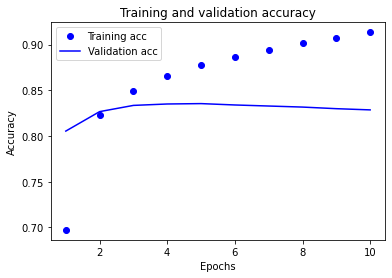

In [65]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [66]:
# 학습된 임베딩 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [67]:
embedding_layer = Embed_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [68]:
# 학습 파라미터 저장
import os
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [69]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word_vector_dim = 300
Embed_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Embed_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [70]:
# 임베딩 파라미터 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_word2vec_file_path, binary=False)
word_vectors.similar_by_word("집")

[('싸움', 0.8058756589889526),
 ('벌레', 0.7932506799697876),
 ('숨기', 0.7906898856163025),
 ('확률', 0.7904202938079834),
 ('챙겨', 0.7902847528457642),
 ('야마카시', 0.7890337705612183),
 ('짜리', 0.788345217704773),
 ('싹', 0.7879202365875244),
 ('죄인', 0.7860131859779358),
 ('유루', 0.7852778434753418)]

In [71]:
# 성능 개선
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [72]:
word2vec.similar_by_word("love")

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [73]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [74]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000  # 어휘 사전의 크기(10000개의 단어)
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 36, 300)           3000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [75]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=500,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
173/173 [==============================] - 7s 38ms/step - loss: 0.6930 - accuracy: 0.5014 - val_loss: 0.6919 - val_accuracy: 0.5049
Epoch 2/10
173/173 [==============================] - 6s 37ms/step - loss: 0.5459 - accuracy: 0.7207 - val_loss: 0.4147 - val_accuracy: 0.8239
Epoch 3/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3742 - accuracy: 0.8419 - val_loss: 0.3698 - val_accuracy: 0.8393
Epoch 4/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3304 - accuracy: 0.8625 - val_loss: 0.3610 - val_accuracy: 0.8423
Epoch 5/10
173/173 [==============================] - 6s 37ms/step - loss: 0.3048 - accuracy: 0.8758 - val_loss: 0.3639 - val_accuracy: 0.8421
Epoch 6/10
173/173 [==============================] - 7s 38ms/step - loss: 0.2888 - accuracy: 0.8835 - val_loss: 0.3740 - val_accuracy: 0.8431
Epoch 7/10
173/173 [==============================] - 6s 37ms/step - loss: 0.2730 - accuracy: 0.8920 - val_loss: 0.3700 - val_accuracy: 0.8416

In [76]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=1)

print(results)

1514/1514 [==============================] - 4s 2ms/step - loss: 0.4052 - accuracy: 0.8335
[0.405231773853302, 0.8334503769874573]


## 회고

앞의 imdb 내용을 참고하여 거의 복사/붙여넣기 하여 실행은 했지만 내용도 엄청 많고 어려워서 뭘 했는지 잘 모르겠다.  
그래도 매 exploration을 통해 모델을 구현하고 학습시키고 평가하는 것들을 반복하다 보니 예전보다 용어에 익숙해져서 만족한다.  
앞으로 나아질 기회는 많기 때문에 계속 화이팅하기로 마음 먹었다!!